In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [2]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [3]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [4]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [5]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej
df = df.sort_values(['Data'], ascending=[True])

In [6]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

In [7]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

#### Tutaj istotne jest że jedna beczka jest energetyczną równażnością $6.3\cdot$[Milion Btu]. Możesz dać slajd o zamianie tych jednostek bo wtedy stała staje się dolar na ilość energii między nimi. Odnosząc to do jazdy samochodem to chyba ma sens. Zamiana jest przed policzeniem zwrotów. 

#### Tylko Btu jest w mianowniku więc zamiast mnożyć to dzielę

https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent

In [8]:
class Portfel:
    """_summary_
    """
    def __init__(self,
                 df,
                 odsetek_ropy:float=.5) -> None:
        self.odsetek_ropy = odsetek_ropy
        self.odsetek_gazu = 1 - odsetek_ropy
        self.usd_na_gaz = np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
        self.usd_na_rope = np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()
    
    @property
    def mean(self):
        return self.odsetek_ropy*self.usd_na_rope.mean() + \
              self.odsetek_gazu*self.usd_na_gaz.mean()
    
    @property
    def var(self):
        return self.odsetek_ropy*self.odsetek_ropy*self.usd_na_rope.var() + \
            self.odsetek_gazu*self.odsetek_gazu*self.usd_na_gaz.var() + \
            2*self.odsetek_gazu*self.odsetek_ropy*self.usd_na_gaz.std()*\
            self.usd_na_rope.std()*np.corrcoef(self.usd_na_gaz[1:],
                                                     self.usd_na_rope[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.usd_na_rope[1:], q)*self.odsetek_ropy + \
            np.quantile(self.usd_na_gaz[1:], q)*self.odsetek_gazu

    def __getitem__(self, key):
        return self.usd_na_rope[1:][key]*self.odsetek_ropy + \
            self.usd_na_gaz[1:][key]*self.odsetek_gazu

In [9]:
space = np.linspace(0, 1, 100)
means = []
vars = []
for i in space:
    p = Portfel(df, odsetek_ropy=i)
    means.append(p.mean)
    vars.append(p.var)

#### Tutaj widać jak zmieniają się miary w zależności od składu portfela. Gaz się nie opłaca.

Text(0.5, 0, 'Odsetek ropy w portfelu')

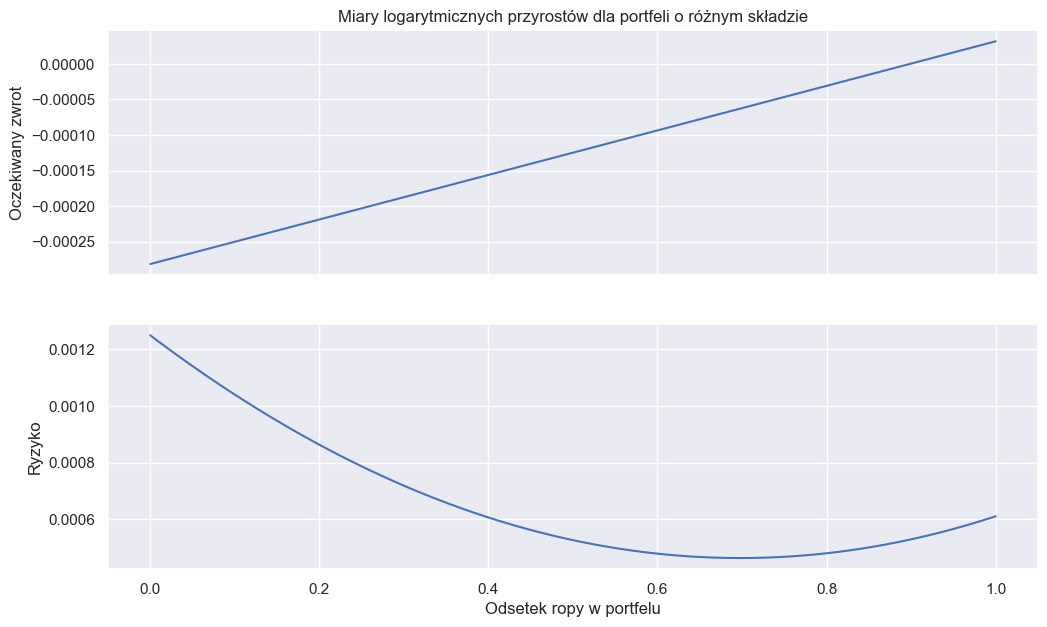

In [13]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
axs[1].plot(space, vars)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')

In [17]:
p[3870]

-0.012713889473348512

In [20]:
p = Portfel(df, odsetek_ropy=.8)
portfel_values = [p[i] for i in range(len(df['przyrosty_log_ropa'][1:])-1)]

c:\Users\xxxAd\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

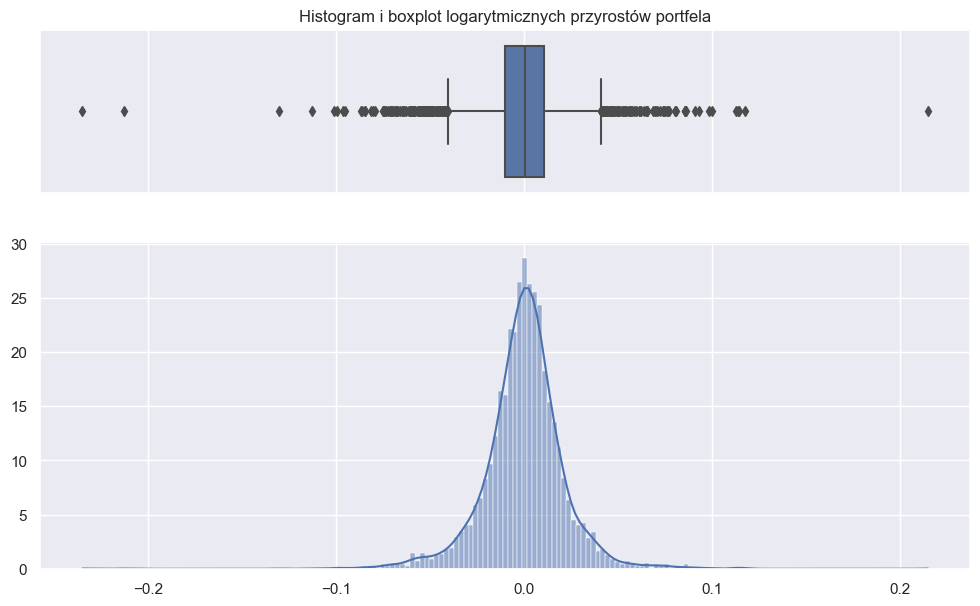

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True,
                       gridspec_kw={'height_ratios': [1, 2]})
sns.histplot(portfel_values, ax=axs[1], bins='auto', stat='density', kde=True)
sns.boxplot(portfel_values, ax=axs[0])
axs[0].set_title('Histogram i boxplot logarytmicznych przyrostów portfela')
axs[1].set_ylabel('')

In [22]:
for q in [.2, .5, .8]:
    print(f'Kwantyl {q}: ', p.quantile(q))

Kwantyl 0.2:  -0.016031456439869318
Kwantyl 0.5:  0.00037678371051994567
Kwantyl 0.8:  0.01636761964004505


c:\Users\xxxAd\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1667: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


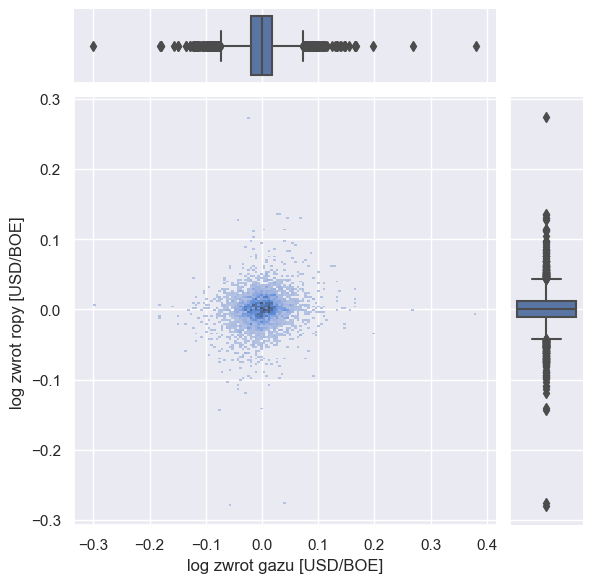

In [59]:

g = sns.JointGrid(x=np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna(), 
            y=np.log(df['Cena ropy [USD/Barrel]']).diff().dropna(),
            size=6)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)
g.set_axis_labels('log zwrot gazu [USD/BOE]', 'log zwrot ropy [USD/BOE]')

In [ ]:
sns.heatmap

Text(0, 0.5, 'Prawdopodobieństwo')

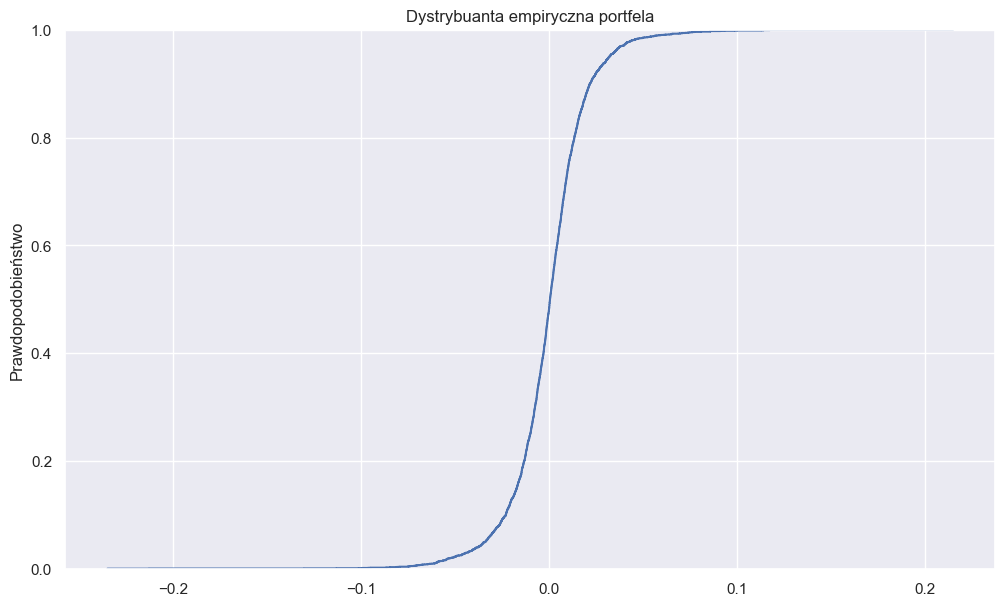

In [53]:
sns.ecdfplot(portfel_values)
plt.title('Dystrybuanta empiryczna portfela')
plt.ylabel('Prawdopodobieństwo')

In [61]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

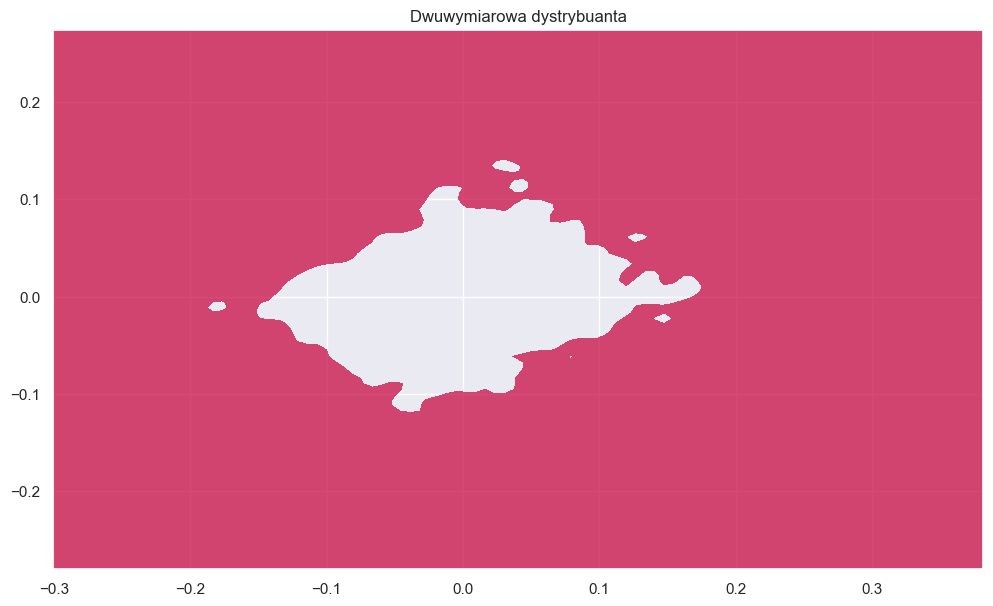

In [90]:
# zapisuję ją bo jest śmieszna

x=np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
y=np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()

xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
n = 100
xi = np.linspace(xmin, xmax, n)
yi = np.linspace(ymin, ymax, n)
xi, yi = np.meshgrid(xi, yi)
cdf = np.zeros_like(xi)
for i in range(n):
    for j in range(n):
        cdf[i,j] = np.mean((x >= xmin) & (x <= xi[i,j]) & (y >= ymin) & (y <= yi[i,j]))

grid_cdf = st.gaussian_kde(np.vstack([x, y])).evaluate(np.vstack([xi.ravel(), yi.ravel()]))
grid_cdf = grid_cdf.reshape((n, n))

fig, ax = plt.subplots()
contour_levels = np.linspace(0, 1, 11)
level = contour_levels[0]
ax.contourf(xi, yi, np.squeeze(grid_cdf), levels=[level, 1], alpha=0.8)
ax.set_title('Dwuwymiarowa dystrybuanta')
plt.show()

In [91]:
def cdf_2d(x, y):
    heatmap = np.zeros((len(x), len(y)))
    x_ = np.linspace(min(x), max(x), len(x))
    y_ = np.linspace(min(y), max(y), len(y))
    for i in range(len(x)):
        for j in range(len(y)):
            heatmap[i][j] = len(x[x < x_[i]])/len(x)*len(y[y < y_[j]])/len(y)
    fig = plt.figure(figsize = (12, 8))
    plt.imshow(heatmap.T, 
                    extent = [min(x), max(x),
                            min(y), max(y)],
                aspect = 'auto',
                origin = 'lower')
    plt.grid(visible = False)
    plt.xlabel('copper')
    plt.ylabel('aluminium')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('')
    plt.title('Dystrybuanta dwuwymiarowa empiryczna dla portfela', fontsize = 25)
    plt.show()

In [92]:
cdf_2d(x, y)